In [1]:
%pylab inline

import numpy as np
import torch

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch import optim
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision import transforms
from densenet import DenseNet

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE = 32
PRINT_TRAINING_INTERVAL = 100

# Data

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


to_pil = transforms.ToPILImage()


trainset = CIFAR10('./CIFAR10', train=True,  transform=transform, download=True)
testset  = CIFAR10('./CIFAR10', train=False, transform=transform, download=True)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


train_x = trainset.train_data
train_y = np.array(trainset.train_labels)
test_x = testset.test_data
test_y = np.array(testset.test_labels)

print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

Files already downloaded and verified
Files already downloaded and verified
train_x: (50000, 32, 32, 3)
train_y: (50000,)
test_x: (10000, 32, 32, 3)
test_y: (10000,)


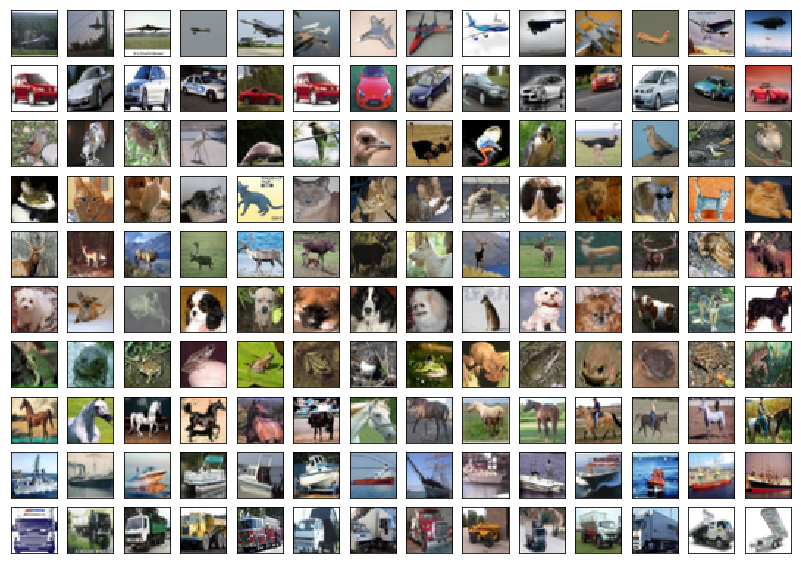

In [4]:
def show_samples(x, y):
    # Convert Tensor to Numpy Array
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy().transpose(0, 2, 3, 1)
        x = (x - x.min()) / (x.max() - x.min())
        x = 1 - x
        x *= 255
        
        x = x.astype('int').astype('float32')
        y = y.cpu().numpy()
    
    x, y = np.array(x), np.array(y)
    labels = np.unique(y)
    
    fig, subplots = pylab.subplots(len(labels), 14, figsize=(14, 10)) # subplots(y축, x축 갯수)
    subplots = subplots.T.reshape(-1)

    for i, p in enumerate(subplots):
        target = x[y == labels[i%len(labels)]]

        idx = np.random.randint(target.shape[0])
        d = target[idx]
        p.get_xaxis().set_visible(False)
        p.get_yaxis().set_visible(False)
        p.imshow(d)
        
show_samples(test_loader.dataset.test_data, test_loader.dataset.test_labels)

# Model

In [5]:
model = DenseNet(24, 0.5, n_class=10, fc_size=10, blocks=[12, 12])
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train

In [6]:
losses = []
step = 0
for x_sample, y_sample in train_loader:
    x_sample, y_sample = Variable(x_sample).cuda(), Variable(y_sample).cuda()
    
    
    # Init Gradients
    optimizer.zero_grad()
    
    # Feedforward    
    y_pred = model(x_sample)
    loss = criterion(y_pred, y_sample)
    loss.backward()
    optimizer.step()
    
    # Add Step
    step += 1
    
    # Logging
    loss = loss.data.cpu().numpy()[0]
    losses.append(loss)
    
    if step % PRINT_TRAINING_INTERVAL == 0:
        loss = np.mean(losses[-PRINT_TRAINING_INTERVAL:])
        print(f'[{step}] loss:{loss:<8.4}')
    
    

RuntimeError: cuda runtime error (2) : out of memory at /home/anderson/Downloads/pytorch/torch/lib/THC/generic/THCStorage.cu:66